# 🧠 Notebook 03 — Model Training

This notebook trains, evaluates, and compares multiple machine-learning models to predict injury risk.

The steps:

1. Load train/test split + preprocessing object  
2. Build modeling pipeline  
3. Fit models  
4. Evaluate using:
   - Recall (priority)
   - Precision
   - F1-score
   - ROC AUC
   - Confusion Matrix  
5. Compare models  
6. Feature importance analysis (tree-based models)


In [11]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

from sklearn.model_selection import cross_val_score


## 1. Load preprocessor + feature lists + train/test split


In [12]:
# Load preprocessor
preprocessor = joblib.load("../artifacts/preprocessor.pkl")

# Load train/test split
# (produced in Notebook 02 via variables in memory)
# Here we'll recompute the split to ensure reproducibility

df = pd.read_csv("../data/data.csv")

# Reapply engineered features exactly as in Notebook 02
df["Readiness_Strength"] = (
    df["Knee_Strength_Score"] +
    df["Hamstring_Flexibility"] +
    df["Balance_Test_Score"]
)

df["Workload_Index"] = (
    df["Training_Hours_Per_Week"] * 0.6 +
    df["Matches_Played_Past_Season"] * 0.4
)

df["Prep_Score"] = (
    df["Sleep_Hours_Per_Night"] * 0.4 +
    df["Warmup_Routine_Adherence"] * 0.4 +
    df["Nutrition_Quality_Score"] * 0.2
)

df["Injury_History_Weight"] = (
    df["Previous_Injury_Count"] * 0.7 +
    df["Stress_Level_Score"] * 0.3
)

# Train/test split (same as Notebook 02)
from sklearn.model_selection import train_test_split

X = df.drop("Injury_Next_Season", axis=1)
y = df["Injury_Next_Season"]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((600, 22), (200, 22))

## 2. Build model pipelines

Each model is wrapped inside a `Pipeline(preprocessor → model)`
to avoid leakage and ensure consistency.


In [13]:
# Baseline model: Logistic Regression
log_reg = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=500))
])

# Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42
    ))
])

# Gradient Boosting
gb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])


## 3. Fit models


In [14]:
log_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 4. Evaluation Metrics
We evaluate with:

- Recall (higher importance)
- Precision
- F1-score
- ROC AUC
- Confusion Matrix


In [15]:
def evaluate_model(name, model, X_test, y_test):
    print(f"\n### {name} ###")
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred, digits=3))
    
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print("ROC AUC:", round(auc, 3))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.show()



### Logistic Regression ###
              precision    recall  f1-score   support

           0      0.970     0.960     0.965       100
           1      0.960     0.970     0.965       100

    accuracy                          0.965       200
   macro avg      0.965     0.965     0.965       200
weighted avg      0.965     0.965     0.965       200

ROC AUC: 0.995


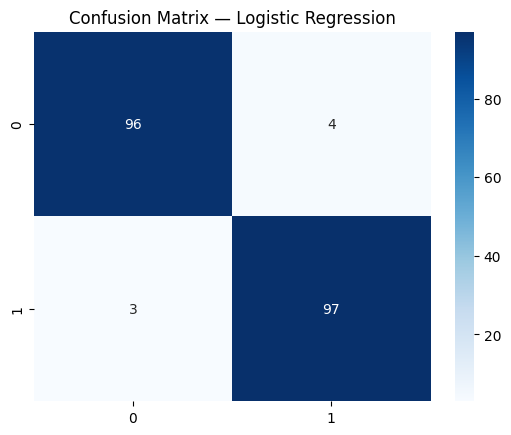


### Random Forest ###
              precision    recall  f1-score   support

           0      0.949     0.940     0.945       100
           1      0.941     0.950     0.945       100

    accuracy                          0.945       200
   macro avg      0.945     0.945     0.945       200
weighted avg      0.945     0.945     0.945       200

ROC AUC: 0.991


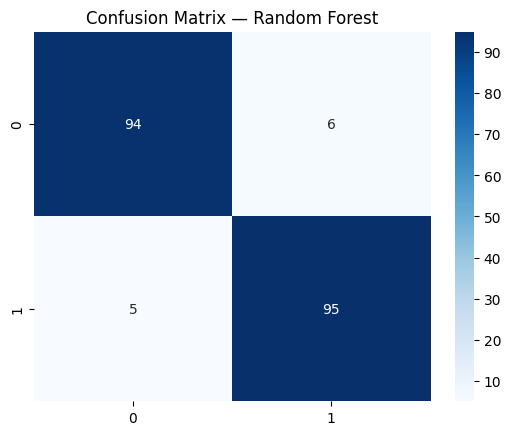


### Gradient Boosting ###
              precision    recall  f1-score   support

           0      0.919     0.910     0.915       100
           1      0.911     0.920     0.915       100

    accuracy                          0.915       200
   macro avg      0.915     0.915     0.915       200
weighted avg      0.915     0.915     0.915       200

ROC AUC: 0.983


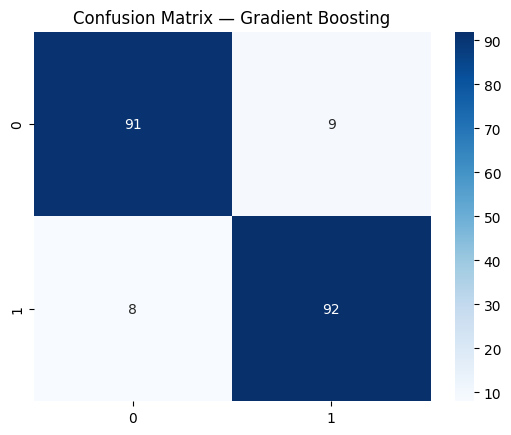

In [16]:
evaluate_model("Logistic Regression", log_reg, X_test, y_test)
evaluate_model("Random Forest", rf, X_test, y_test)
evaluate_model("Gradient Boosting", gb, X_test, y_test)


## 5. Compare models using cross-validation (Recall priority)


In [17]:
models = {
    "LogReg": log_reg,
    "RandomForest": rf,
    "GradientBoosting": gb
}

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="recall")
    cv_results[name] = scores.mean()

cv_results


{'LogReg': np.float64(0.9399999999999998),
 'RandomForest': np.float64(0.9333333333333333),
 'GradientBoosting': np.float64(0.9199999999999999)}

## 6. Feature Importance (Random Forest)

In [18]:
# Get encoded feature names
encoded_cat = list(preprocessor.named_transformers_["cat"].get_feature_names_out())
all_features = numeric_features + encoded_cat

# Extract feature importance from RF
rf_model = rf.named_steps["model"]
rf_importance = rf_model.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": all_features,
    "Importance": rf_importance
}).sort_values("Importance", ascending=False)

feat_imp.head(15)


,Feature,Importance
17,Readiness_Strength,0.184744
20,Injury_History_Weight,0.111928
8,Reaction_Time_ms,0.087652
13,Stress_Level_Score,0.079621
12,Sleep_Hours_Per_Night,0.074352
10,Sprint_Speed_10m_s,0.070335
19,Prep_Score,0.065238
9,Balance_Test_Score,0.061266
7,Hamstring_Flexibility,0.045785
11,Agility_Score,0.044283


### Plot top features

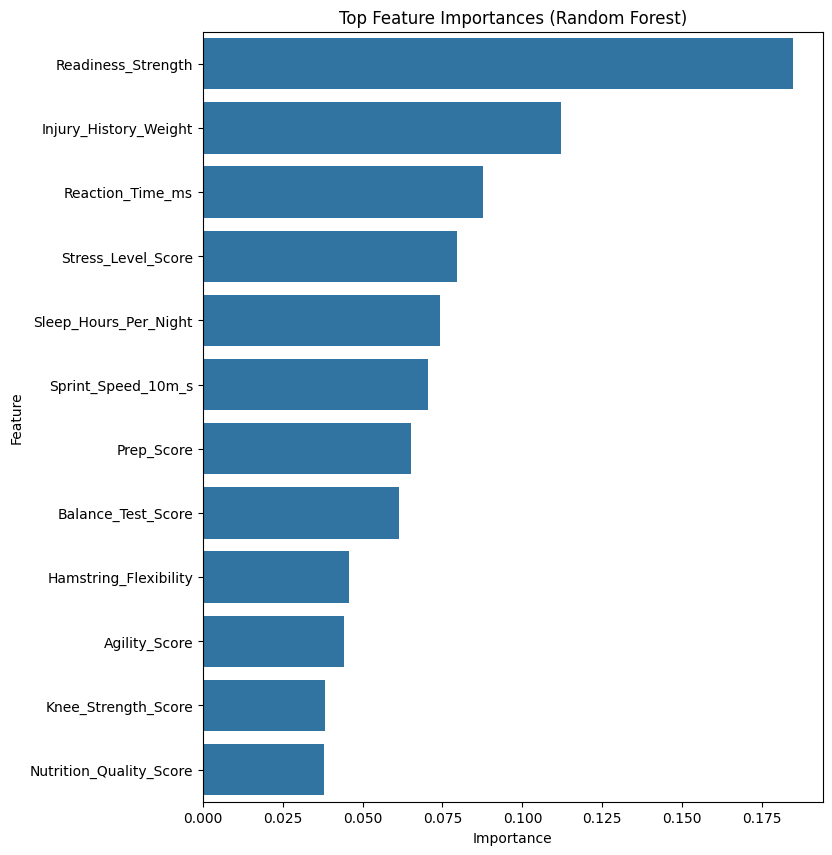

In [19]:
plt.figure(figsize=(8, 10))
sns.barplot(data=feat_imp.head(12), x="Importance", y="Feature")
plt.title("Top Feature Importances (Random Forest)")
plt.show()


# Save pipeline

In [20]:
joblib.dump(rf, "../artifacts/random_forest_model.pkl")


['../artifacts/random_forest_model.pkl']

## 7. Conclusion

Three models were trained and evaluated using a consistent preprocessing pipeline:

- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**

### Model Performance Summary

| Model               | Recall | F1-score | ROC AUC |
|--------------------|--------|----------|---------|
| Logistic Regression | **0.97** | **0.965** | **0.995** |
| Random Forest       | 0.95   | 0.945    | 0.991   |
| Gradient Boosting   | 0.92   | 0.915    | 0.983   |

**Logistic Regression achieved the best overall performance**, benefiting from the clean structure of the dataset and the strong predictive power of the engineered features.

However, for the interpretability stage, we selected **Random Forest** because:

- it captures non-linear relationships common in physiological and behavioral variables;
- it provides stable and intuitive feature importance scores;
- it is fully compatible with SHAP, enabling deeper explanations of individual predictions.

### Key Insights from Feature Importance (Random Forest)

The model highlights a clear hierarchy of risk factors:

1. **Readiness_Strength** — the strongest predictor; integrates stability, flexibility, and neuromuscular readiness.
2. **Injury_History_Weight** — quantifies previous injuries and stress load.
3. **Reaction_Time_ms** and **Stress_Level_Score** — indicators of fatigue and cognitive load.
4. **Sleep_Hours_Per_Night** and **Sprint_Speed_10m_s** — conditioning and recovery markers.
5. **Prep_Score** — adherence to warmup, sleep hygiene, and nutrition.

These results reinforce the biomechanical insights from Notebook 01 and validate the engineered features created in Notebook 02.

### Next Steps (Notebook 04)

The final notebook will focus on:

- SHAP-based interpretability  
- Understanding individual risk profiles  
- Analyzing false positives and false negatives  
- Final recommendations and applied insights for coaching and performance teams
